In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
extended_kalman_filter = import_local_or_github('extended_kalman_filter', directory='../Utility')

Fetching from: 
<Response [200]>


In [6]:
import requests
import zipfile

def download_data(filename, giturl=None, unzip=True):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    if giturl is None:
      giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Data/' + filename

    r = requests.get(giturl)
    print('Fetching from: ')
    print(r)

    # Store the file to the colab working directory
    with open(filename, 'wb') as f:
      f.write(r.content)
    f.close()

    if unzip:
        print('unzipping...')
        with zipfile.ZipFile(filename, 'r') as zip_ref:
          zip_ref.extractall('.')  # extracts to new directory

# Download sample trajectories

These trajectories were generated with the script:
* `generate_training_data.py`

And then zipped with the command:
* `zip -r planar_drone_trajectories.zip planar_drone_trajectories`

Here we download them and unzip them so they are available in the local (e.g. colab) workspace.

In [7]:
download_data('planar_drone_trajectories.zip')

Fetching from: 
<Response [200]>
unzipping...


# Load the data

The data consists of a directory full of short .hdf files describing trajectories that are a few seconds long.

In [8]:
def load_trajectory_data(data_path):
    #data_path = 'planar_drone_trajectories'
    all_fnames = os.listdir(data_path)

    traj_list = []
    for fname in all_fnames:
        fname = os.path.join(data_path, fname)
        trajec = pd.read_hdf(fname)
        traj_list.append(trajec)

    print('Number of trajectories: ')
    print(len(traj_list))

    return traj_list

In [16]:
traj_list = load_trajectory_data('planar_drone_trajectories')

Number of trajectories: 
3001


# Clean up the data

The fact that I needed to do this was obvious after looking at the distribution of the state values -- the histograms had outliers.

We don't want trajectories that have absurdly high values for any of the states or measurements. So we will toss out any trajectories that have values over 100 for any of those.

In [29]:
def clean_trajectory_data(traj_list, max_state_value=100):
    cols_to_analyze = traj_list[0].keys().tolist()
    cols_to_analyze.remove('objid')

    bad_trajs = []
    for i in range(len(traj_list)):
        if traj_list[i][cols_to_analyze].abs().max().max() > max_state_value:
            bad_trajs.append(i)

    traj_list_good = [obj for i, obj in enumerate(traj_list) if i not in bad_trajs]

    print('Number of good trajectories: ')
    print(len(traj_list_good))

    return traj_list_good

In [30]:
traj_list = clean_trajectory_data(traj_list)

Number of good trajectories: 
2924


# Validate that the data matches dynamics and measurement functions f & h

In [31]:
traj = traj_list[0]

In [32]:
traj

,time,objid,theta,theta_dot,x,x_dot,z,z_dot,j1,j2,sensor_optic_flow,sensor_theta,sensor_theta_dot,sensor_accel_x,sensor_accel_z
5,0.5,1361,-0.623119,-3.394045,-2.054536,0.420086,8.802912,-1.396671,1.417001,14.593813,0.047721,-0.623119,-3.394045,8.516521,2.041086
6,0.6,1361,-0.785398,0.148457,-1.965198,1.396263,8.669624,-1.295159,0.559970,15.043392,0.161052,-0.785398,0.148457,10.637284,0.827284
7,0.7,1361,-0.700556,1.548383,-1.773284,2.426457,8.545113,-1.180569,0.519700,14.976417,0.283958,-0.700556,1.548383,9.654442,1.639228
8,0.8,1361,-0.480755,2.847633,-1.486085,3.272217,8.438080,-0.929274,0.355830,14.694786,0.387792,-0.480755,2.847633,6.795591,3.219071
9,0.9,1361,-0.151513,3.737208,-1.131792,3.737320,8.364182,-0.523339,-0.003934,14.313629,0.446824,-0.151513,3.737208,2.160418,4.339650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,9.0,1361,0.009759,0.000580,0.424629,0.182254,8.174760,-0.334669,0.001366,11.552593,0.022295,0.009759,0.000580,-0.112742,1.742043
91,9.1,1361,0.009988,0.003996,0.442288,0.170881,8.150003,-0.160466,0.000251,11.873852,0.020967,0.009988,0.003996,-0.118594,2.063260
92,9.2,1361,0.010419,0.004623,0.458775,0.158772,8.144272,0.045858,0.001806,12.055061,0.019495,0.010419,0.004623,-0.125598,2.244407
93,9.3,1361,0.011107,0.009138,0.474013,0.145843,8.160080,0.270295,-0.006565,12.054663,0.017873,0.011107,0.009138,-0.133887,2.243919


In [33]:
states = ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot']
controls = ['j1', 'j2']
measurements = ['sensor_optic_flow', 'sensor_theta', 'sensor_theta_dot', 'sensor_accel_x', 'sensor_accel_z']

In [34]:
X = traj[states]
U = traj[controls]
Y = traj[measurements]

# Visualize the trajectories

### Great opportunity to use AI.

All code below is Claude generated with the following prompts. No this won't create the most beautiful plots (but with more interaction it probably could). But this is an incredibly efficient way to visualize your data.

##### Prompt 1:
I have a bunch of trajectories stored as a list of pandas dataframes. The trajectories are short 2-dimensional paths with an orientation. I want to create a figure with python that shows a large random sampling of these trajectories so I can easily visualize them. Can you write two functions, one that visualizes a single trajectory (with matplotlib), and a second function that can plot an arbitrary number of trajectories efficiently in one master figure?

The columns of the dataframes I want to plot are: x, z (positions) and theta (orientation).

##### Refinement prompts:

1. Can you make the trajectory plots in the style of the attached picture? [attached picure was a trajectory style copy/paste from this paper: https://www.biorxiv.org/content/10.1101/2024.11.04.621976v1.abstract]

2. In the multiple trajectories plot, I want each trajectory to show up as its own axis. Also, you can get rid of the axis labels and tick values.

##### Prompt 2:

Ok, now I also want to plot a grid of histograms that show the distribution of a given list of columns of the dataframe.



In [35]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
import pandas as pd


def plot_single_trajectory(df, ax=None, marker_spacing=1,
                          color='black', alpha=0.9,
                          triangle_size=0.15):
    """
    Plot a single trajectory using triangles to show position and orientation.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with columns 'x', 'z', 'theta'
    ax : matplotlib.axes.Axes, optional
        Axes to plot on. If None, creates new figure
    marker_spacing : int
        Show triangle marker every N points
    color : str
        Color for the trajectory triangles
    alpha : float
        Transparency (0-1)
    triangle_size : float
        Size of triangle markers

    Returns:
    --------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    # Plot triangles along the path
    for i in range(0, len(df), marker_spacing):
        x, z, theta = df.iloc[i][['x', 'z', 'theta']]

        # Create triangle pointing in direction of theta
        # Triangle vertices relative to center
        tip = np.array([triangle_size, 0])
        left = np.array([-triangle_size/2, -triangle_size/2])
        right = np.array([-triangle_size/2, triangle_size/2])

        # Rotation matrix
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        rot = np.array([[cos_t, -sin_t], [sin_t, cos_t]])

        # Rotate and translate vertices
        tip_rot = rot @ tip + [x, z]
        left_rot = rot @ left + [x, z]
        right_rot = rot @ right + [x, z]

        triangle = Polygon([tip_rot, left_rot, right_rot],
                          facecolor=color, edgecolor=color,
                          alpha=alpha)
        ax.add_patch(triangle)

    ax.set_xlabel('X Position')
    ax.set_ylabel('Z Position')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

    # Auto-scale to fit all triangles
    margin = triangle_size * 2
    ax.set_xlim(df['x'].min() - margin, df['x'].max() + margin)
    ax.set_ylim(df['z'].min() - margin, df['z'].max() + margin)

    return ax


def plot_multiple_trajectories(trajectory_list, n_samples=None,
                               grid_shape=None, figsize=(15, 15),
                               marker_spacing=2, color='black',
                               alpha=0.7, triangle_size=0.1):
    """
    Plot multiple trajectories, each in its own subplot.

    Parameters:
    -----------
    trajectory_list : list of pd.DataFrame
        List of trajectory DataFrames with columns 'x', 'z', 'theta'
    n_samples : int, optional
        Number of random trajectories to plot. If None, plots all
    grid_shape : tuple (rows, cols), optional
        Grid layout for subplots. If None, automatically determined
    figsize : tuple
        Figure size (width, height)
    marker_spacing : int
        Show triangle marker every N points
    color : str or list
        Color(s) for trajectories. If single color, all use same color.
        If list, cycles through colors
    alpha : float
        Transparency for all trajectories
    triangle_size : float
        Size of triangle markers

    Returns:
    --------
    fig, axes : matplotlib figure and axes array
    """
    # Sample trajectories if requested
    if n_samples is not None and n_samples < len(trajectory_list):
        indices = np.random.choice(len(trajectory_list), n_samples, replace=False)
        trajectories_to_plot = [trajectory_list[i] for i in indices]
    else:
        trajectories_to_plot = trajectory_list

    n_traj = len(trajectories_to_plot)

    # Determine grid shape if not provided
    if grid_shape is None:
        cols = int(np.ceil(np.sqrt(n_traj)))
        rows = int(np.ceil(n_traj / cols))
    else:
        rows, cols = grid_shape

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = np.array(axes).flatten()  # Make it easy to iterate

    # Handle color options
    if isinstance(color, str):
        colors = [color] * n_traj
    else:
        colors = [color[i % len(color)] for i in range(n_traj)]

    # Plot each trajectory in its own subplot
    for traj_idx, df in enumerate(trajectories_to_plot):
        ax = axes[traj_idx]
        traj_color = colors[traj_idx]

        # Plot triangles along the path
        for i in range(0, len(df), marker_spacing):
            x, z, theta = df.iloc[i][['x', 'z', 'theta']]

            # Create triangle pointing in direction of theta
            tip = np.array([triangle_size, 0])
            left = np.array([-triangle_size/2, -triangle_size/2])
            right = np.array([-triangle_size/2, triangle_size/2])

            # Rotation matrix
            cos_t, sin_t = np.cos(theta), np.sin(theta)
            rot = np.array([[cos_t, -sin_t], [sin_t, cos_t]])

            # Rotate and translate vertices
            tip_rot = rot @ tip + [x, z]
            left_rot = rot @ left + [x, z]
            right_rot = rot @ right + [x, z]

            triangle = Polygon([tip_rot, left_rot, right_rot],
                              facecolor=traj_color, edgecolor=traj_color,
                              alpha=alpha)
            ax.add_patch(triangle)

        # Set axis limits with margin
        margin = triangle_size * 3
        ax.set_xlim(df['x'].min() - margin, df['x'].max() + margin)
        ax.set_ylim(df['z'].min() - margin, df['z'].max() + margin)
        ax.set_aspect('equal')

        # Remove axis labels and ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Hide any unused subplots
    for idx in range(n_traj, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()

    return fig, axes


def plot_trajectory_histograms(trajectory_list, columns, n_samples=None,
                              grid_shape=None, figsize=(15, 10),
                              bins=30, color='steelblue', alpha=0.7,
                              show_stats=True):
    """
    Plot histograms showing the distribution of specified columns across all trajectories.

    Parameters:
    -----------
    trajectory_list : list of pd.DataFrame
        List of trajectory DataFrames
    columns : list of str
        List of column names to plot histograms for
    n_samples : int, optional
        Number of random trajectories to include. If None, uses all
    grid_shape : tuple (rows, cols), optional
        Grid layout for subplots. If None, automatically determined
    figsize : tuple
        Figure size (width, height)
    bins : int or str
        Number of bins for histograms or binning strategy
    color : str
        Color for histogram bars
    alpha : float
        Transparency for histogram bars
    show_stats : bool
        Whether to show mean and std on each plot

    Returns:
    --------
    fig, axes : matplotlib figure and axes array
    """
    # Sample trajectories if requested
    if n_samples is not None and n_samples < len(trajectory_list):
        indices = np.random.choice(len(trajectory_list), n_samples, replace=False)
        trajectories_to_use = [trajectory_list[i] for i in indices]
    else:
        trajectories_to_use = trajectory_list

    n_cols = len(columns)

    # Determine grid shape if not provided
    if grid_shape is None:
        cols_per_row = int(np.ceil(np.sqrt(n_cols)))
        rows = int(np.ceil(n_cols / cols_per_row))
    else:
        rows, cols_per_row = grid_shape

    fig, axes = plt.subplots(rows, cols_per_row, figsize=figsize)
    if n_cols == 1:
        axes = np.array([axes])
    axes = np.array(axes).flatten()

    # Collect data for each column across all trajectories
    for col_idx, col_name in enumerate(columns):
        ax = axes[col_idx]

        # Concatenate all values from this column across all trajectories
        all_values = []
        for df in trajectories_to_use:
            if col_name in df.columns:
                all_values.extend(df[col_name].values)

        all_values = np.array(all_values)

        # Plot histogram
        n, bins_edges, patches = ax.hist(all_values, bins=bins,
                                         color=color, alpha=alpha,
                                         edgecolor='black', linewidth=0.5)

        # Add statistics if requested
        if show_stats:
            mean_val = np.median(all_values)
            std_val = np.std(all_values)
            ax.axvline(mean_val, color='red', linestyle='--',
                      linewidth=2, label=f'Median: {mean_val:.3f}')
            ax.text(0.02, 0.98, f'Std: {std_val:.3f}',
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_xlabel(col_name, fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(f'{col_name} Distribution', fontsize=12)
        ax.grid(True, alpha=0.3)

        if show_stats:
            ax.legend(loc='upper right')

    # Hide any unused subplots
    for idx in range(n_cols, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()

    return fig, axes




### Look at individual trajectories in x-z plane

There should be a diversity of unique looking trajectories.

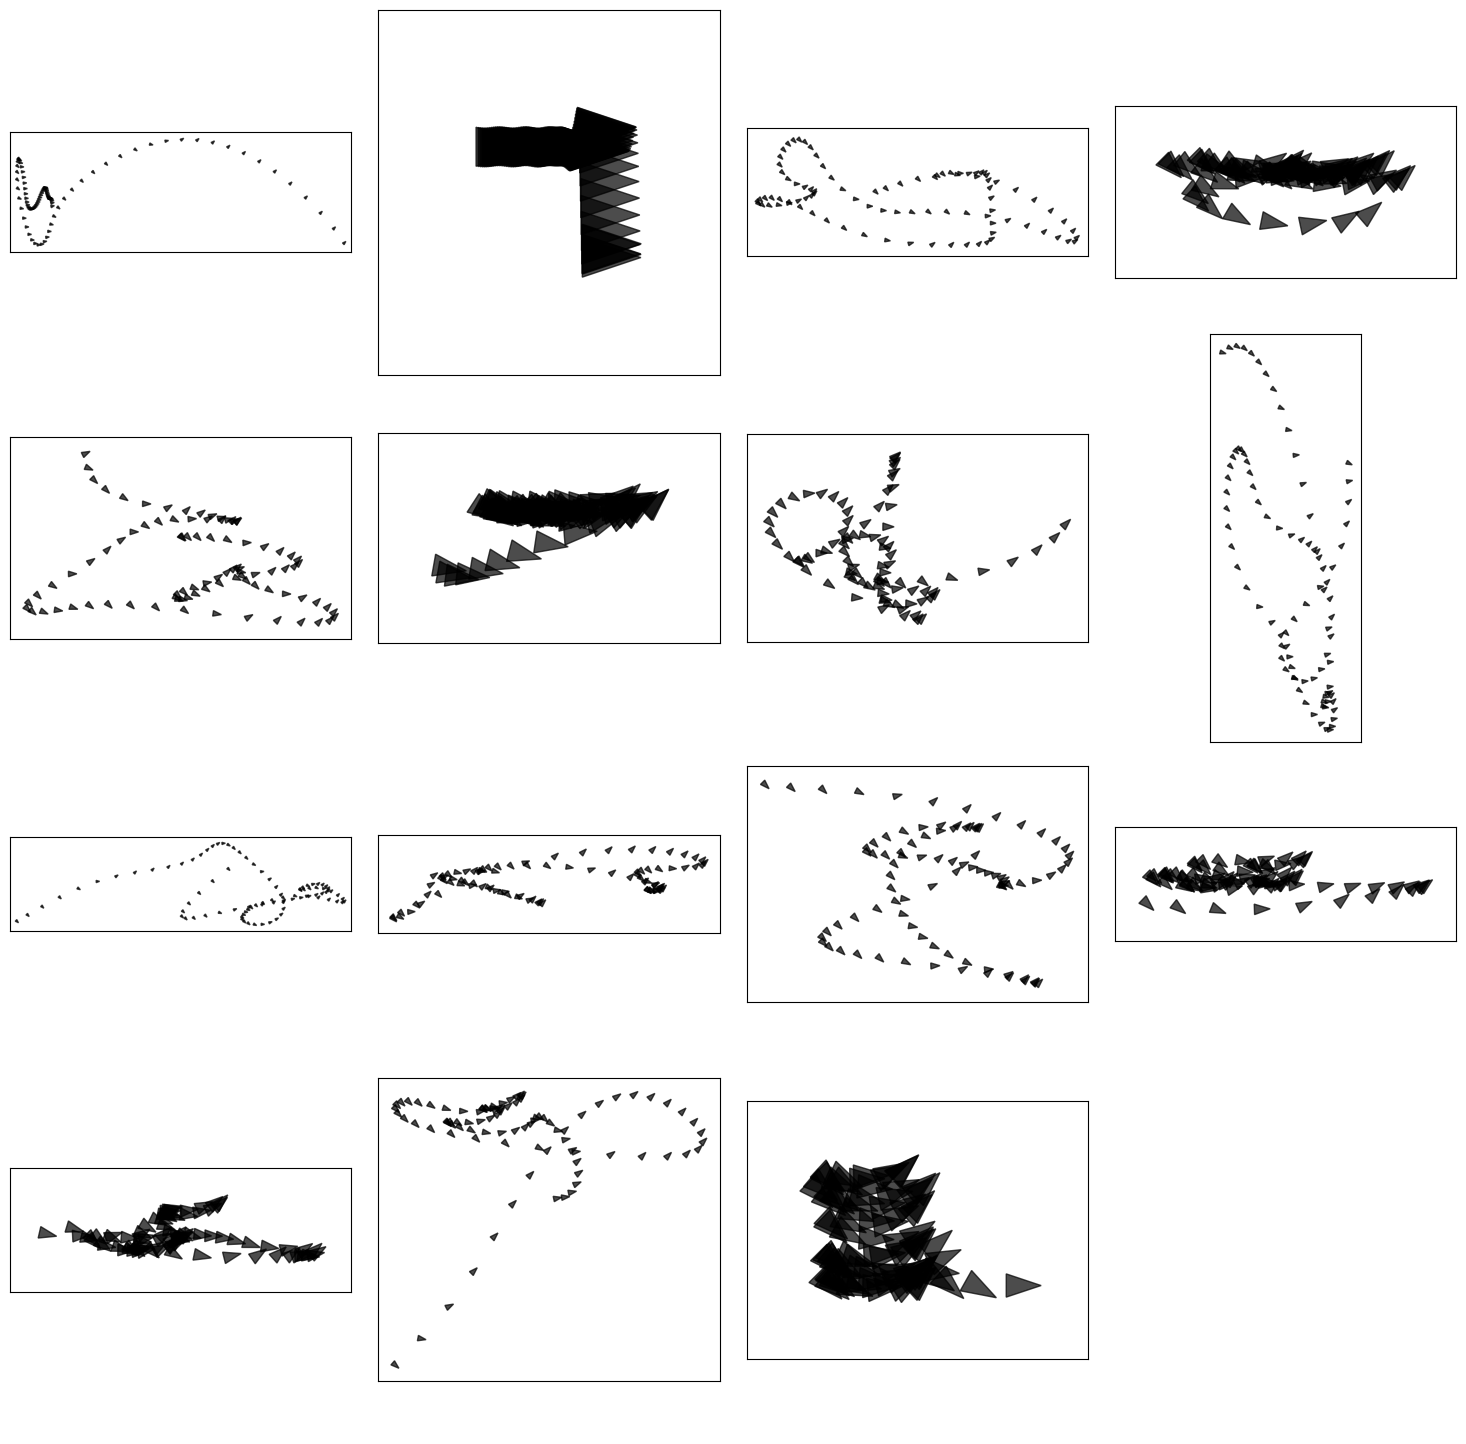

In [36]:
# Plot multiple trajectories (like the reference image)
fig, ax = plot_multiple_trajectories(traj_list, n_samples=15,
                                     marker_spacing=1, triangle_size=0.12)
plt.tight_layout()
plt.show()

### Look at the distribution of the states

These should span the state space you anticipate encountering, not have outliers, and be nicely distributed (avoid bimodal distributions, or non continuous distributions).

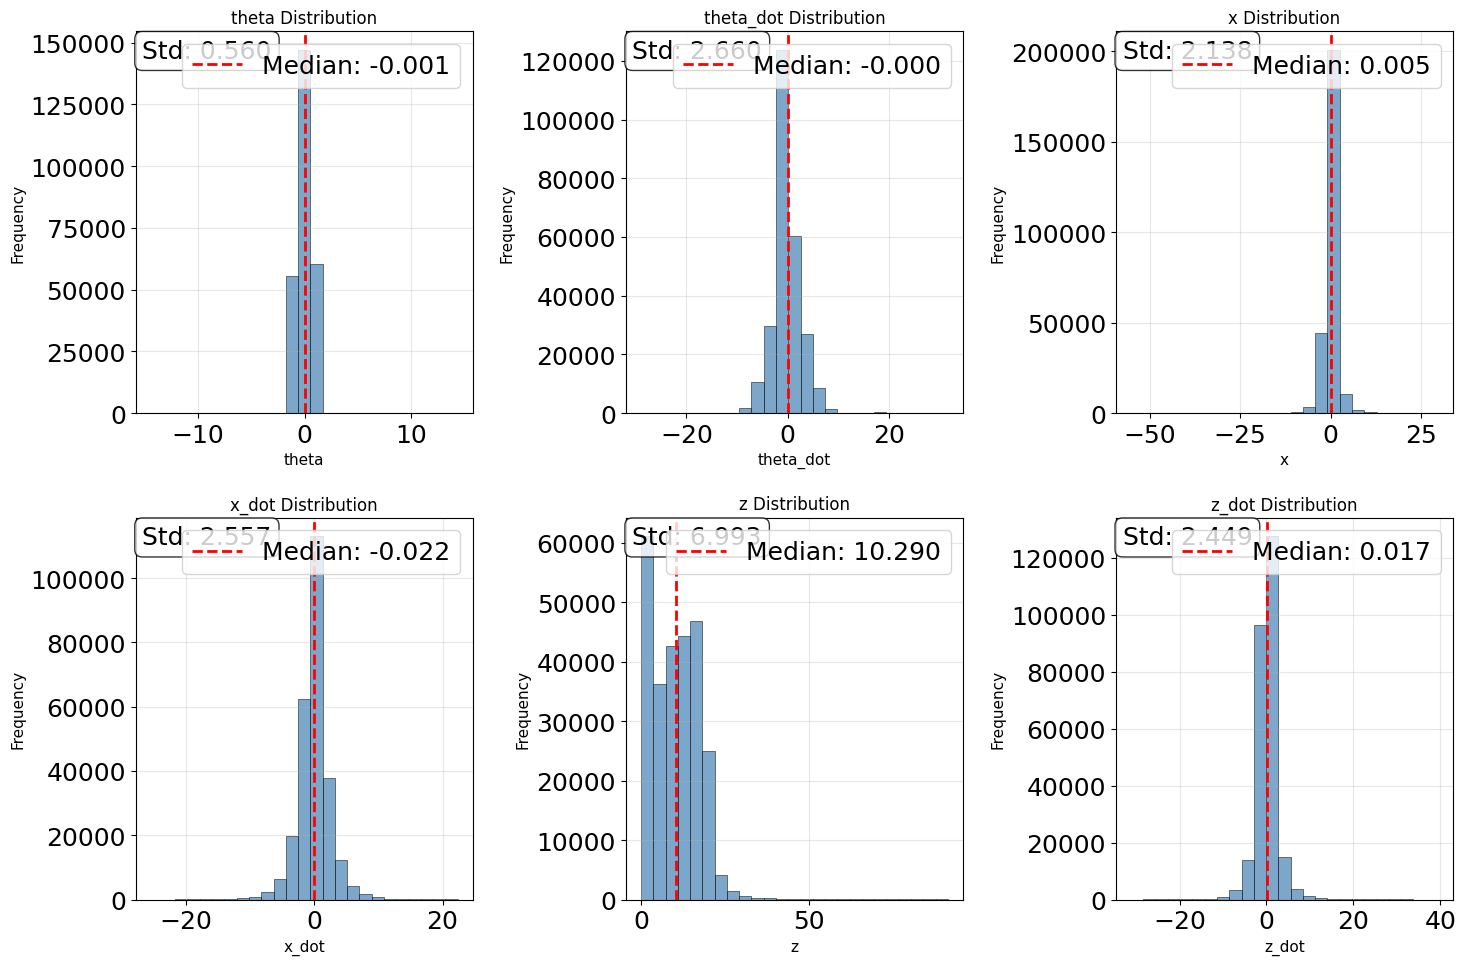

In [37]:
# Plot histograms for specified columns
fig, axes = plot_trajectory_histograms(traj_list,
                                      columns=['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot'],
                                      bins=25)

### Look at features correlated with observability

You could calculte the observability for each trajectory, but this will be really slow. Instead look at the features that are strongly correlated to observability.

In our case, accel_x is correlated to observability, and so is z (small z is good) and x_dot (large x_dot is good). We can see z and x_dot in the graphs above, so let's look at accel_x.



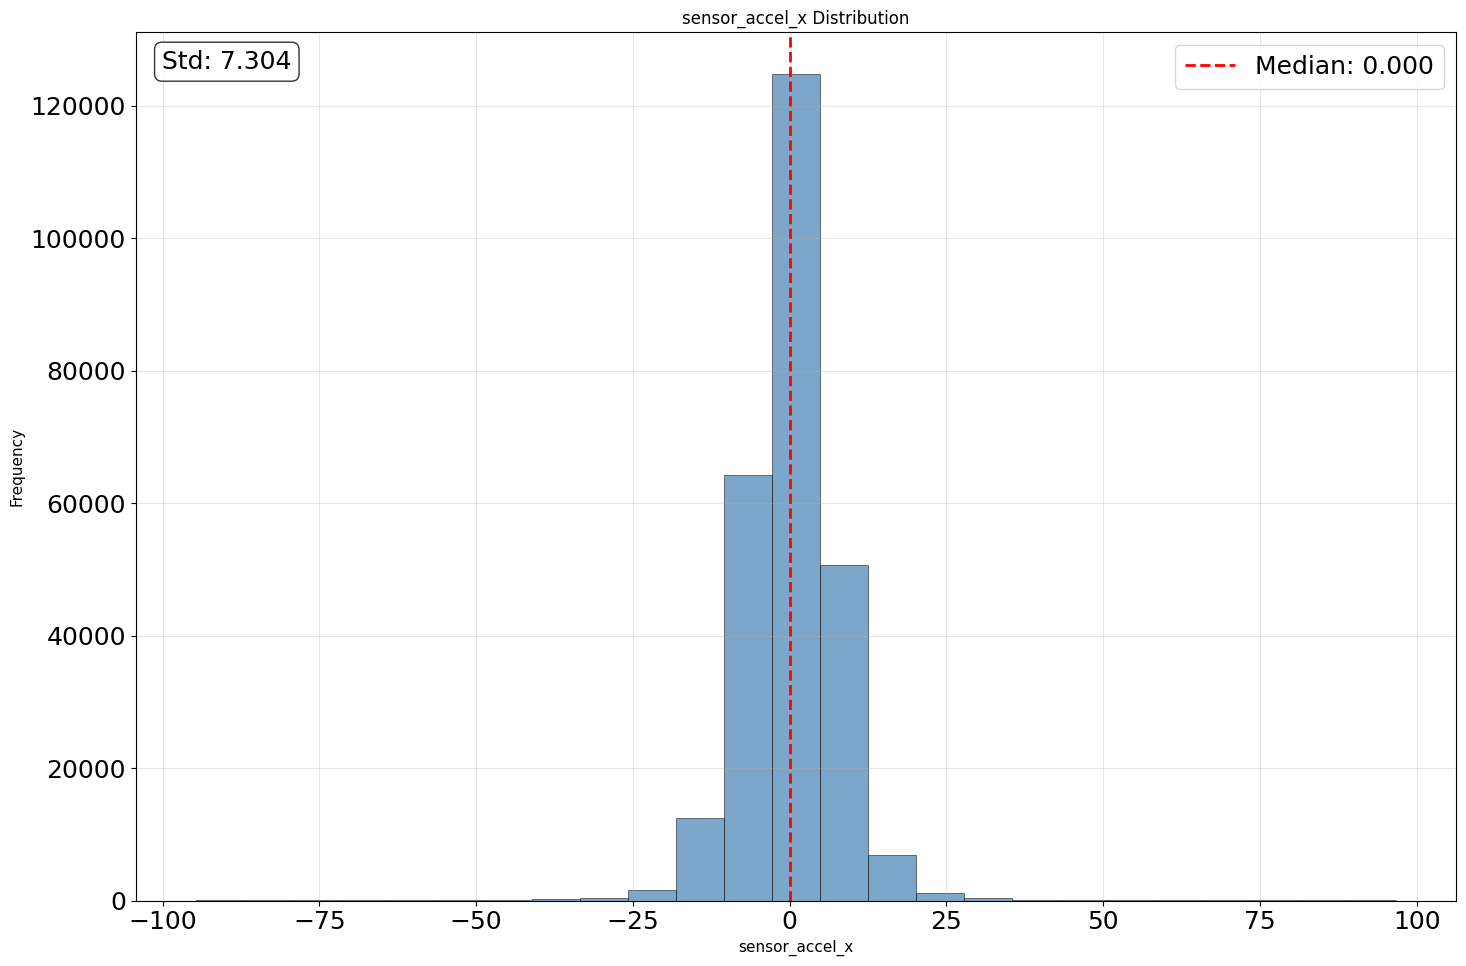

In [38]:
# Plot histograms for specified columns
fig, axes = plot_trajectory_histograms(traj_list,
                                      columns=['sensor_accel_x'],
                                      bins=25)

# What to look for

1. Make sure the trajectories themselves look as expected, are unique, smooth, and cover a wide variety of motifs.
2. The histograms should cover the full range of states that you anticipate your testing trajectories to cover. *Remember* neural networks are bad at extrapolating beyond training data, so these histograms effectively set the range over which you can hope your ANN to work well.
3. There should be a good fraction of the distribution that has observable motifs in it. We may have more unobservable data in here than is ideal -- we could drop some fraction of the really low accel_x trajectories to speed up training.  
4. The histograms should ideally be somewhat uniformly distributed, but this is very hard for a dynamically constrained model. Here most of the states are gaussian distributions around zero, which is okay, but we should keep this in mind when training and evaluating our network.

# Exercises

1. What changes if you do not filter out the bad trajectories?